In [13]:
import pandas as pd
import numpy as np
import torch
from torch import tensor, Tensor, nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.functional import F
import matplotlib.pyplot as plt
import matplotlib as mpl
import torchvision as tv
import torcheval as te
from random import choice
from pathlib import Path

from sklearn.preprocessing import MinMaxScaler

import warnings

mpl.rcParams['image.cmap'] = 'gray'

In [14]:
# Possible modes: default, balanced, debug
MODE = "debug"

In [15]:
datapath = Path('../data/256')
img_folder = datapath
train_csv = datapath/'train.csv' if MODE == "default" else datapath/'balanced.csv' if MODE == "balanced" else datapath/'debug.csv'
train_csv

WindowsPath('../data/256/debug.csv')

In [16]:
class BCancerDataset(Dataset):
    def __init__(self, annot_df: pd.DataFrame, slc: slice, scaler: callable): # Maybe transforms here ?
        super(BCancerDataset, self).__init__()
        self.scaler = scaler

        # prep annotations
        self.annotations = annot_df.iloc[slc]
        self.annotations['path'] = img_folder/(self.annotations['patient_id'].astype(str)+ '_' +self.annotations['image_id'].astype(str)+'.png')


    def __len__(self) -> int:
        return len(self.annotations)

    def __getitem__(self, item) -> (Tensor, Tensor):
        image_data = tensor(
            self.scaler.transform(tv.io.read_image(str(self.annotations['path'].iloc[item]), tv.io.ImageReadMode.GRAY).reshape(-1, 1)), dtype=torch.float32).squeeze()
        label = (torch.tensor(self.annotations['cancer'].iloc[item])).type(torch.LongTensor)
        return image_data, label


def gen_ds(split: float, annot_f: Path, bs=128) -> (Dataset, Dataset):
    if split > 1:
        raise Exception(' > 1')
    f_data = np.arange(0, 255, 1).reshape(-1, 1)
    scaler = MinMaxScaler()
    scaler.fit(f_data)

    bs = bs
    annotdf = pd.read_csv(annot_f)
    len_df = len(annotdf)
    split_pt = int(len_df * split)
    print(split_pt)
    train_dl = DataLoader(BCancerDataset(annotdf, slice(0, split_pt), scaler), batch_size=bs, shuffle=True, drop_last=True)
    val_dl = DataLoader(BCancerDataset(annotdf, slice(split_pt, len_df), scaler), batch_size=bs, shuffle=True, drop_last=True)
    return train_dl, val_dl




In [17]:
with warnings.catch_warnings():
    warnings.filterwarnings(action='ignore')
    if MODE == "debug":
        train_dl, val_dl = gen_ds(0.8, train_csv, bs=10)
    else:
        train_dl, val_dl = gen_ds(0.8, train_csv, bs=128)

160


tensor(0) 160


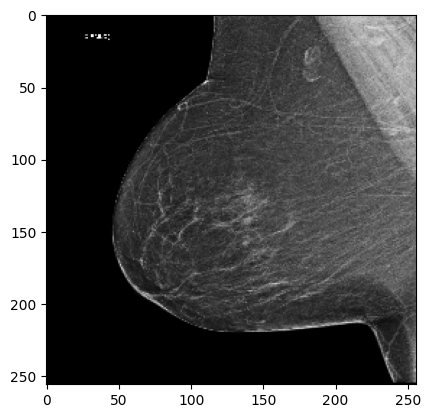

In [23]:
idx = choice(range(0, len(train_dl.dataset)))
print(train_dl.dataset[idx][1], len(train_dl.dataset))
plt.imshow(train_dl.dataset[idx][0].reshape(-1, 256),)

In [19]:
train_dl.dataset[0][0].shape

torch.Size([65536])

In [20]:
class CancerNN(nn.Module):
    def __init__(self, in_s: int, out_s:int):
        super(CancerNN, self).__init__()
        self.layers = nn.ModuleList([
            nn.Linear(in_s, 1024),
            nn.SELU(),
            nn.Linear(1024, 512),
            nn.SELU(),
            nn.Linear(512, 256),
            nn.SELU(),
            nn.Linear(256, out_s),
            nn.Sigmoid()
        ])

    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x

In [21]:
model = CancerNN(train_dl.dataset[0][0].shape[0], 1)
loss_fn = F.binary_cross_entropy_with_logits
opt = optim.SGD(model.parameters(), 0.02)

In [22]:
for e in range(0, 1):
    for xb,yb in train_dl:
        preds = model(xb)
        loss = loss_fn(preds, yb.view(-1, 1).float())
        loss.backward()
        opt.step()
        opt.zero_grad()
    print(loss)



KeyboardInterrupt: 

In [ ]:
def pfbeta_torch(preds, labels, beta=1):
    preds = preds.clip(0, 1)
    y_true_count = labels.sum()
    ctp = preds[labels==1].sum()
    cfp = preds[labels==0].sum()
    beta_squared = beta * beta
    c_precision = ctp / (ctp + cfp)
    c_recall = ctp / y_true_count
    if c_precision > 0 and c_recall > 0:
        result = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall)
        return result
    else:
        return 0.0


In [ ]:
argmscore = np.array([(model(x).argmax(dim=1) == y).float().mean() for x,y in val_dl]).mean()
f1_acc = np.array([pfbeta_torch(model(x).detach(), y) for x, y in val_dl]).mean()

argmscore, f1_acc



